# Assignment 2: Task 2

## STL-10 CNN Classification

The second and final part of the assignment requires us to design and apply a CNN model to classify the complex dataset STL-10, this time making use of the PyTorch package.

To effectivly do so, we will firsly properly download, configure and visualise the data. Afterwards, we reduce our problem to the simpler case of 2-class classification and generalise it to the computationaly costlier 10-class classification. Our research will conclude with several tests on the CNN parameters, to deepen and comprehend a bit more the blackbox it represents. The comparison between such test will sustained in their corrisponding efficecy metrix, from which the most relevant will be the accuracy.


In [30]:
# coding: utf-8

## Environment check
This cell ensures you are running the intended environment. If it fails, either activate that envaronment or comment this cell out.

In [2]:
# Verify the environment is correct
import os
# if not 'CONDA_DEFAULT_ENV' in os.environ or os.environ['CONDA_DEFAULT_ENV'] != 'dl':
#    raise RuntimeError('This exercise requires \'dl\' conda environment activated')

## Imports
We import numpy and matplotlib for data handling and visualization, and PyTorch for building and training CNNs.

In [3]:
# ===================
# for array manipulations, etc.
# ===================
import random
import numpy as np

# ===================
# for visualization
# ===================
from matplotlib import pyplot as plt

# ===================
# pytorch for CNN related things
# ===================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Load STL-10 (binary format)
If the dataset is already in the machine, we've developed the fuction `load_split()` to read the binary image/label files and reshape images to `(N, 3, 96, 96)`.
On the other hand, one may download the data directly from the cell.

In [4]:
# ===========================================================================
# Load the dataset (images + labels)
# ===========================================================================

# ===================
# function to load the dataset and format the data as required for further processing
# ===================
# inputs:
#    split: string denoting whether the train or the test data is to be loaded
# outputs:
#    X: dataset inputs (images)
#    y: dataset outputs (labels for the images)
# ===================
def load_split(split):
    X_path = 'stl10_binary/{}_X.bin'.format(split)
    y_path = 'stl10_binary/{}_y.bin'.format(split)
    X = np.fromfile(X_path, dtype=np.uint8).reshape((-1, 3, 96, 96))
    X = np.moveaxis(X, 2, 3) # convert column-major to row-major (swap H/W)
    y = np.fromfile(y_path, dtype=np.uint8) # data type seems to be important here...
    y = y - 1 #convert range [1,10] to [0,9]
    print('-----------------')
    print('Loaded split "{}" with sizes: Images {}, labels {}'.format(split, X.shape, y.shape))
    return X, y


# ===================
# Download and extract the dataser if it's not already present
# ===================
import os
if not os.path.exists('stl10_binary'):
  print('Downloading and extracting STL-10 dataset...')
  !wget http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
  !tar -xzf stl10_binary.tar.gz
  print('Dataser download and extracted')

# ===================
# load the training and test datasets
# ===================
full_train_X, full_train_y = load_split('train')
full_test_X, full_test_y = load_split('test')

# ===================
# read the names of the classes in the dataset
# ===================
with open('stl10_binary/class_names.txt') as f:
    full_class_names = f.readlines()

 # ===================
 # strip trailing whitespace
 # ===================
full_class_names = [name.strip() for name in full_class_names]

# ===================
# print the list of names of all classes
# ===================
print('-----------------')
print('The classes in the dataset are: ')
print(list(enumerate(full_class_names)))

--2026-02-04 22:22:16--  http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2640397119 (2.5G) [application/x-gzip]
Saving to: ‘stl10_binary.tar.gz’

stl10_binary.tar.gz 100%[===================>]   2.46G  4.80MB/s    in 29m 20s 

2026-02-04 22:51:36 (1.43 MB/s) - ‘stl10_binary.tar.gz’ saved [2640397119/2640397119]

Dataser download and extracted
-----------------
Loaded split "train" with sizes: Images (5000, 3, 96, 96), labels (5000,)
-----------------
Loaded split "test" with sizes: Images (8000, 3, 96, 96), labels (8000,)
-----------------
The classes in the dataset are: 
[(0, 'airplane'), (1, 'bird'), (2, 'car'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'horse'), (7, 'monkey'), (8, 'ship'), (9, 'truck')]


## 3) Visualize samples
We define a helper to display an image with its class name. The STL-10 images are stored as channels-first `(3, 96, 96)`, so we move axes for plotting.

In [5]:
# ===========================================================================
# Explore a few samples of the dataset
# (repeat the following cell for different output by pressing Ctrl-Enter on it instead of Shift-Enter)
# ===========================================================================

# ===================
# function to show an example image and its label
# ===================
# inputs:
#    X: image
#    y: label
#    class_names: list of names of all classes so that the class name corresponding to the label can be identified
# outputs:
#    None
# ===================
def visualize_sample(X, y, class_names):
    X_vis = np.moveaxis(X, 0, 2) # convert Channel,Width,Height order to W,H,C
    plt.figure()
    plt.imshow(X_vis, interpolation='nearest')
    plt.axis('off')
    plt.title('Class id={}, Name={}'.format(y, class_names[y]))

### Show one random training image
Run this cell multiple times to see different images.

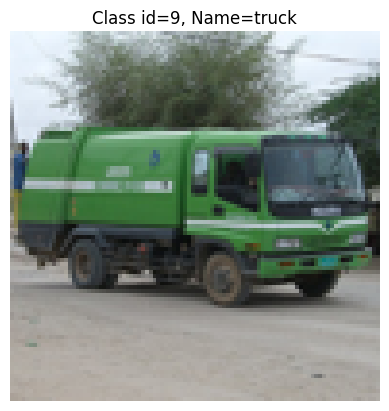

In [6]:
# ===================
# choose a random image and display it
# you may run this cell multiple times to get an idea of the different images in the dataset
# alternatively, modify the function 'visualize_sample' to display several (4/8/16) different images along with their labels
# ===================
i = random.randint(0, full_train_X.shape[0]-1)
visualize_sample(full_train_X[i],
                 full_train_y[i],
                 full_class_names)

In [ ]:
# Display a small grid of samples
fig = plt.figure(figsize=(10, 8))
for i in range(9):
    j = random.randint(0, len(full_train_X))
    img, lbl = full_train_X[j], full_train_y[j]
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(np.transpose(img, (1,2,0)))
    ax.set_title(full_class_names[lbl])
    ax.axis("off")
plt.tight_layout()
plt.show()

# Dataset summary in a table
print("Classes:", full_class_names)
print("Image shape (C,H,W):", full_train_X[0][0].shape, "(= 3 x 96 x 96)")
print("Image dtype:", full_train_X[0][0].dtype)
print("Label dtype:", type(full_train_X[0][1]))



# def visualize_multiple_sample(X, y, class_names, n):
#     for i in range(n):
#         i = random.randint(0, full_train_X.shape[0]-1)
#         X_vis = np.moveaxis(X[i], 0, 2) # convert Channel,Width,Height order to W,H,C
#         plt.figure()
#         plt.imshow(X_vis, interpolation='nearest')
#         plt.axis('off')
#         plt.title('Class id={}, Name={}'.format(y[i], class_names[y[i]]))

# visualize_multiple_sample(full_train_X,
#                           full_train_y,
#                           full_class_names,
#                           10)

In [7]:
#  # Display a small grid of samples
# def denorm(x):
#     # undo Normalize(mean=0.5,std=0.5) => back to [0,1]
#     return (x * 0.5) + 0.5

# fig = plt.figure(figsize=(10, 8))
# for i in range(9):
#     img, lbl = train_set[random.randint(0, len(train_set)-1)]
#     ax = plt.subplot(3, 3, i+1)
#     ax.imshow(np.transpose(denorm(img).numpy(), (1,2,0)))
#     ax.set_title(CLASS_NAMES[lbl])
#     ax.axis("off")
# plt.tight_layout()
# plt.show()

# # Dataset summary table-ish
# print("Classes:", CLASS_NAMES)
# print("Image shape (C,H,W):", train_set[0][0].shape, "(= 3 x 96 x 96)")
# print("Image dtype:", train_set[0][0].dtype)
# print("Label dtype:", type(train_set[0][1]))

## 4) Build a 2-class subset (cat vs ship)
To make training faster and easier to debug, we first restrict the dataset to only two classes.

- Old class IDs: `cat=3`, `ship=8` (based on STL-10 order)
- New class IDs: `cat→0`, `ship→1`

In [8]:
# ===========================================================================
# First, let us train a 2-class classifier.
# ===========================================================================

# ===================
# Let's select from the dataset only samples of classes 'cat' and 'ship'.
# We have arbitrarily chosen these two classes.
# You may try some other pair of classes if you wish to.
# ===================
ID_C1_OLD, ID_C2_OLD = 3, 8 # C1: CAT, C2: SHIP
ID_C1_NEW, ID_C2_NEW = 0, 1

# ===================
# function to delete all the classes other than the cat and ship classes
# ===================
# inputs:
#    X: images from all classes
#    y: labels from all classes
#    split: train / test
# outputs:
#    X_out: images from only cats and ships
#    y_out: labels from only cats and ships
# ===================
def subsplit_two_classes(X, y, split):

    indices = np.where(np.logical_or(y==ID_C1_OLD, y==ID_C2_OLD))
    X_out = X[indices]
    y_out = y[indices]
    y_out = (y_out == ID_C1_OLD).astype(int) * ID_C1_NEW + (y_out == ID_C2_OLD).astype(int) * ID_C2_NEW
    print('Created "{}" subsplit with only 2 classes with sizes: Images {}, labels {}'.format(split, X_out.shape, y_out.shape))
    return X_out, y_out

# ===================
# make the training and test datasets so that they contain only the two classes of interest
# ===================
train_two_classes_X, train_two_classes_y = subsplit_two_classes(full_train_X,
                                                                full_train_y,
                                                                'train')

test_two_classes_X, test_two_classes_y = subsplit_two_classes(full_test_X,
                                                              full_test_y,
                                                              'test')

class_names_two_classes = [full_class_names[i] for i in (ID_C1_OLD, ID_C2_OLD)]

Created "train" subsplit with only 2 classes with sizes: Images (1000, 3, 96, 96), labels (1000,)
Created "test" subsplit with only 2 classes with sizes: Images (1600, 3, 96, 96), labels (1600,)


### Visualize the 2-class subset
You should see only **cats** and **ships** here.

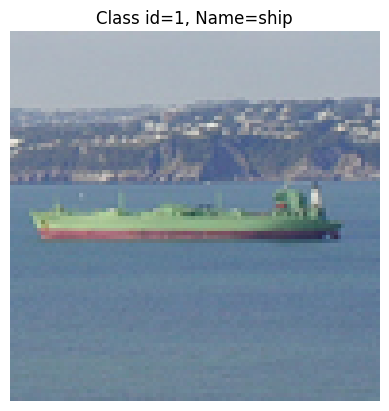

In [9]:
# ===================
# visualize some examples from the modified datasets
# ===================
i = random.randint(0, train_two_classes_X.shape[0]-1)
visualize_sample(train_two_classes_X[i],
                 train_two_classes_y[i],
                 class_names_two_classes)

## 5) PyTorch Dataset + DataLoader
We wrap numpy arrays in a `Dataset` so PyTorch can batch them using `DataLoader`.

We create loaders for:
- 2-class train/test
- 10-class train/test

In [10]:
# ===========================================================================
# Wrap our dataset into pytorch Dataset class so it can further be used in DataLoader for batch grouping
# ===========================================================================
class ArrayDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

 # ===================
 # set the batch size here
 # ===================
BATCH_SIZE = 64
# ===================
# load the training and test datasets for the two-class classification problem
# https://pytorch.org/docs/stable/data.html
# ===================
loader_two_classes_train = DataLoader(dataset = ArrayDataset(train_two_classes_X, train_two_classes_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_two_classes_test = DataLoader(dataset = ArrayDataset(test_two_classes_X, test_two_classes_y),
                                     batch_size=1,
                                     shuffle=True)

# ===================
# load the training and test datasets for the ten-class classification problem
# ===================
loader_ten_classes_train = DataLoader(dataset = ArrayDataset(full_train_X, full_train_y),
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  drop_last=True)

loader_ten_classes_test = DataLoader(dataset = ArrayDataset(full_test_X, full_test_y),
                                 batch_size=1,
                                 shuffle=True)

## 6) Define the CNN (Acne-style)
Architecture:
- 4× (Conv → BatchNorm → ReLU → MaxPool)
- Flatten → FC(256) → Dropout → FC(num_classes)

Normalization is done inside `forward()`:
- Convert `uint8` to float in [0,1]
- Normalize to approximately [-1,1] via `(x-0.5)/0.5`

In [31]:
# ===========================================================================
# Define neural network
# ===========================================================================

# Change the number of fliters:
#     num_filters = [3, 6, 12, 24, 64]
# Apply it with one, two, three and four layers (including the dense one-)


class CNN(nn.Module):

  # ===================
  # A simple CNN (Acne-CNN style) adapted for STL-10 (96x96 RGB)
  # Conv -> ReLU -> MaxPool stacks + 2 FC layers
  # ===================
    def __init__(self, num_out_classes):
        super(CNN, self).__init__()

        # Input: (N, 3, 96, 96)
        self.conv1 = nn.Conv2d(3, 24, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(24)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)   # -> (N, 42, 48, 48)

        self.conv2 = nn.Conv2d(24, 24, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(24)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)   # -> (N, 24 24, 24)

        self.conv3 = nn.Conv2d(24, 24, kernel_size=3, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(24)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)   # -> (N, 24, 12, 12)

        self.conv4 = nn.Conv2d(24, 24, kernel_size=3, padding=1, bias=False)
        self.bn4   = nn.BatchNorm2d(24)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)   # -> (N, 24, 6, 6)

        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(24 * 6 * 6, 24)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(24, num_out_classes)

    def forward(self, x):
        # x is uint8 in [0,255]
        x = x.float() / 255.0
        # normalize to [-1, 1]
        x = (x - 0.5) / 0.5

        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x





## 7) Accuracy function

We compute **classification accuracy** by taking `argmax` over logits and comparing with ground-truth labels.

In [19]:
# ===========================================================================
# function to compute the accuracy of the CNN
# ===========================================================================
def compute_accuracy(data_loader,
                     cnn,
                     split,
                     print_output = True):

    cnn.eval() # sets the model into evaluation mode
    total_accuracy = 0
    total_samples = 0

    for i, batch in enumerate(data_loader):

        # get the inputs and labels
        X_batch, y_batch = batch

        # calculate predictions given a batch of samples
        predictions_batch = cnn(X_batch)

        # convert each prediction into a class id
        _, vals = torch.max(predictions_batch, 1)

        # calculate the amount of predicted class ids matching the ground truth and increment counters
        total_accuracy += (vals == y_batch.type(torch.long)).int().sum()
        total_samples += y_batch.shape[0]

        out_accuracy = int(total_accuracy) * 1.0 / total_samples

    if print_output:
        print('Accuracy over "{}" split is {:02f}%'.format(split, 100 * out_accuracy))

    return 100 * out_accuracy

## 8) Evaluate before training (2-class)
Before training, accuracy should be close to random guessing (~50%).

In [20]:
# ===========================================================================
# create an instance of the above defined CNN class
# ===========================================================================
cnn_two_classes = CNN(num_out_classes = 2)

# ===========================================================================
# compute the accuracy of the CNN... we have not yet trained it, so what do you expect the accuracy to be??
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')

RuntimeError: running_mean should contain 3 elements not 8

## 9) Training loop
We train using:
- **Loss:** `CrossEntropyLoss` (multi-class classification)
- **Optimizer:** Adam

Optionally we track accuracy each epoch (slower on CPU, but useful for learning).

In [14]:
# ===========================================================================
# function for training the model...
# ===========================================================================
def train(cnn,
          loader_train,
          loader_test,
          num_epochs,
          learning_rate = 0.001,
          track_accuracy = False):

    # ===================
    # define the loss to be minimized
    # https://pytorch.org/docs/stable/nn.html#crossentropyloss
    # ===================
    # *choose loss here
    criterion = nn.CrossEntropyLoss()


    # ===================
    # create an optimizer
    # You can read more about optimizers here: https://pytorch.org/docs/stable/optim.html
    # You may try with different optimizers and check if that makes any difference
    # For any one optimizer, try changing the learning rate and observe the effect.
    # ===================

    # *choose optimizer here
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

    # ===================
    # set the model into training mode
    # ===================
    cnn.train()

    tr_acc = []
    ts_acc = []

    # ===================
    # In each epoch, run the optimizer operation on each batch
    # ===================
    for epoch in range(num_epochs):

        epoch_loss = 0.0

        for i, batch in enumerate(loader_train):

            X_batch, y_batch = batch
            y_batch = y_batch.type(torch.long)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            # *write forward pass
            predictions_batch = cnn(X_batch)


            # calculate loss for the provided predictions and ground truth labels
            # =====================================================
            loss = criterion(predictions_batch, y_batch)

            epoch_loss += float(loss)

            # backward pass
            loss.backward()

            # update learnable parameters according to gradients
            optimizer.step()

        # ===================
        # track the training and test accuracy.
        # note that this adds quite a bit to the training time,
        # as things are running on the cpu currently.
        # this is usually a good debugging tool to see how the training is progressing
        # and is usually done when people train such networks on gpus.
        # ===================
        if track_accuracy:
            tr_acc.append(compute_accuracy(data_loader = loader_train,
                                           cnn = cnn,
                                           split = 'train',
                                           print_output = False))
            ts_acc.append(compute_accuracy(data_loader = loader_test,
                                           cnn = cnn,
                                           split = 'test',
                                           print_output = False))

        epoch_loss /= len(loader_train)
        print('Epoch {}/{} training loss {:02f}'.format(epoch+1, num_epochs, epoch_loss))

    if track_accuracy:
        plt.figure()
        plt.plot(np.array(tr_acc))
        plt.plot(np.array(ts_acc))
        plt.legend(['training accuracy', 'test accuracy'])
        plt.xlabel('training iterations')
        plt.show()
        plt.close()

    print('Finished Training')

## 10) Train the 2-class CNN
After training, train accuracy should increase, and test accuracy should improve above chance.

/tmp/ipython-input-70619504.py:61: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  epoch_loss += float(loss)


Epoch 1/20 training loss 0.492937
Epoch 2/20 training loss 0.303662
Epoch 3/20 training loss 0.228357
Epoch 4/20 training loss 0.154003
Epoch 5/20 training loss 0.135673
Epoch 6/20 training loss 0.143506
Epoch 7/20 training loss 0.108164
Epoch 8/20 training loss 0.108014
Epoch 9/20 training loss 0.095366
Epoch 10/20 training loss 0.068713
Epoch 11/20 training loss 0.065242
Epoch 12/20 training loss 0.043004
Epoch 13/20 training loss 0.049737
Epoch 14/20 training loss 0.030531
Epoch 15/20 training loss 0.025986
Epoch 16/20 training loss 0.019715
Epoch 17/20 training loss 0.010175
Epoch 18/20 training loss 0.014014
Epoch 19/20 training loss 0.015985
Epoch 20/20 training loss 0.080564


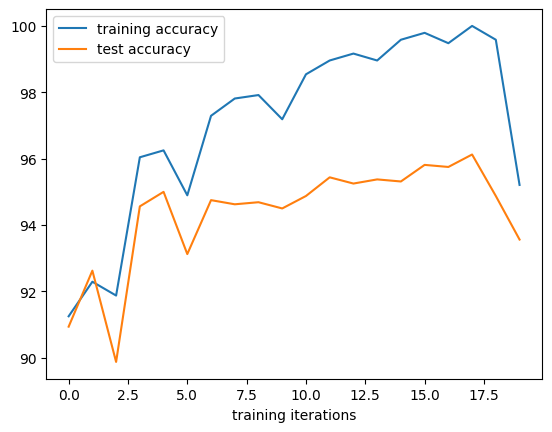

Finished Training
Accuracy over "train" split is 95.208333%
Accuracy over "test" split is 93.562500%


93.5625

In [15]:
# ===========================================================================
# call the train function and wait for the magic to unfold ;)
# ===========================================================================
train(cnn = cnn_two_classes,
      loader_train = loader_two_classes_train,
      loader_test = loader_two_classes_test,
      num_epochs = 20,
      track_accuracy = True)

# ===========================================================================
# Let's reevaluate accuracy now. Did the magic happen?
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')




### 10-class CNN with 5 layers and increasing number of filters.

Epoch 1/15 training loss 2.075653
Epoch 2/15 training loss 1.469592
Epoch 3/15 training loss 1.311577
Epoch 4/15 training loss 1.127352
Epoch 5/15 training loss 0.994789
Epoch 6/15 training loss 0.901889
Epoch 7/15 training loss 0.753582
Epoch 8/15 training loss 0.613553
Epoch 9/15 training loss 0.483957
Epoch 10/15 training loss 0.368684
Epoch 11/15 training loss 0.269226
Epoch 12/15 training loss 0.172786
Epoch 13/15 training loss 0.130418
Epoch 14/15 training loss 0.106446
Epoch 15/15 training loss 0.094370


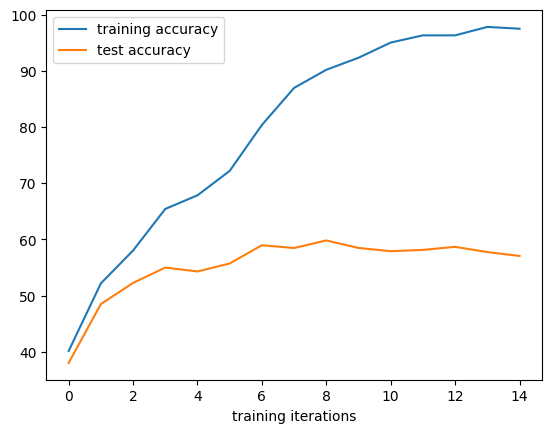

Finished Training
Accuracy over "train" split is 97.536058%
Accuracy over "test" split is 57.050000%


57.05

In [17]:
# Now, let's try to apply the same approach to multi-class classification problem.
# Remember that the original dataset has 10 classes.
# So all that needs to be done is create a new CNN with 10 output classes, and train once again.


# ===========================================================================
# create a new instance of the CNN class, to do the classification for all the ten classes
# ===========================================================================
cnn_ten_classes = CNN(num_out_classes = 15)



# ===========================================================================
# train this new CNN... this will take a while (about 20-30 seconds per epoch)
# ===========================================================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ===========================================================================
# compute the accuracy with the trained CNN...
# ===========================================================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

### 10-class CNN with 3 filters per layer

Epoch 1/15 training loss 2.707234
Epoch 2/15 training loss 2.492303
Epoch 3/15 training loss 2.323321
Epoch 4/15 training loss 2.218926
Epoch 5/15 training loss 2.145634
Epoch 6/15 training loss 2.057208
Epoch 7/15 training loss 1.977369
Epoch 8/15 training loss 1.908092
Epoch 9/15 training loss 1.851094
Epoch 10/15 training loss 1.800240
Epoch 11/15 training loss 1.767132
Epoch 12/15 training loss 1.743160
Epoch 13/15 training loss 1.711729
Epoch 14/15 training loss 1.692987
Epoch 15/15 training loss 1.664054


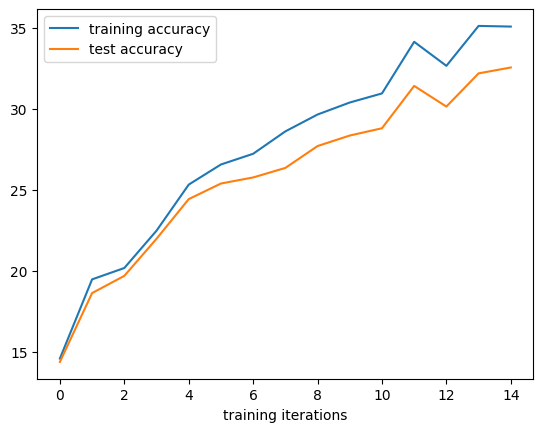

Finished Training
Accuracy over "train" split is 35.016026%
Accuracy over "test" split is 32.550000%


32.550000000000004

In [22]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

### 10-class CNN with 6 filters per layer

Epoch 1/15 training loss 2.575524
Epoch 2/15 training loss 2.316730
Epoch 3/15 training loss 2.052825
Epoch 4/15 training loss 1.795539
Epoch 5/15 training loss 1.657824
Epoch 6/15 training loss 1.591702
Epoch 7/15 training loss 1.535007
Epoch 8/15 training loss 1.504267
Epoch 9/15 training loss 1.483095
Epoch 10/15 training loss 1.462540
Epoch 11/15 training loss 1.440344
Epoch 12/15 training loss 1.429786
Epoch 13/15 training loss 1.420919
Epoch 14/15 training loss 1.399383
Epoch 15/15 training loss 1.371171


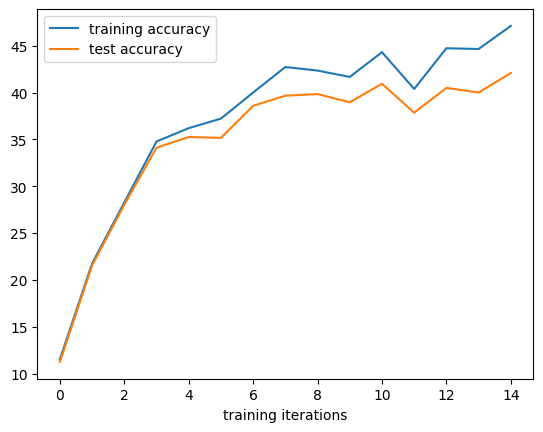

Finished Training
Accuracy over "train" split is 47.135417%
Accuracy over "test" split is 42.087500%


42.0875

In [24]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

### 10-class CNN with 12 filters per layer
---



Epoch 1/15 training loss 2.534402
Epoch 2/15 training loss 1.921685
Epoch 3/15 training loss 1.613089
Epoch 4/15 training loss 1.530306
Epoch 5/15 training loss 1.468072
Epoch 6/15 training loss 1.408173
Epoch 7/15 training loss 1.380233
Epoch 8/15 training loss 1.326178
Epoch 9/15 training loss 1.303012
Epoch 10/15 training loss 1.252729
Epoch 11/15 training loss 1.229506
Epoch 12/15 training loss 1.202841
Epoch 13/15 training loss 1.183558
Epoch 14/15 training loss 1.163180
Epoch 15/15 training loss 1.110320


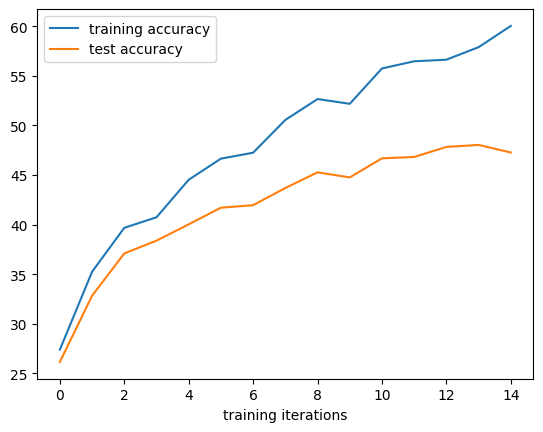

Finished Training
Accuracy over "train" split is 60.076122%
Accuracy over "test" split is 47.275000%


47.275

In [29]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

### 10-class CNN with 24 filters per layer
---

Epoch 1/15 training loss 2.396979
Epoch 2/15 training loss 1.623808
Epoch 3/15 training loss 1.410526
Epoch 4/15 training loss 1.279705
Epoch 5/15 training loss 1.193547
Epoch 6/15 training loss 1.084384
Epoch 7/15 training loss 1.000078
Epoch 8/15 training loss 0.943554
Epoch 9/15 training loss 0.843821
Epoch 10/15 training loss 0.752990
Epoch 11/15 training loss 0.680703
Epoch 12/15 training loss 0.633828
Epoch 13/15 training loss 0.580388
Epoch 14/15 training loss 0.475302
Epoch 15/15 training loss 0.426388


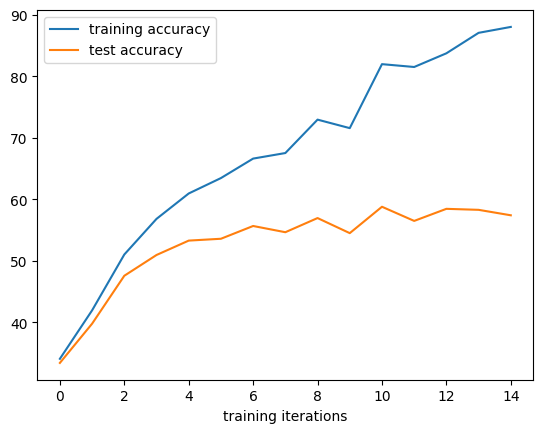

Finished Training
Accuracy over "train" split is 88.020833%
Accuracy over "test" split is 57.412500%


57.4125

In [32]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')